СРАВНЕНИЕ АНАЛИТИЧЕСКИХ И ЧИСЛЕННЫХ ПРОИЗВОДНЫХ

Начальное состояние:
  r₀ = (34150.328, 18574.082, -32794.222) км
  v₀ = (-0.030405, -0.265034, 0.455176) км/с

1. ЧИСЛЕННЫЕ ПРОИЗВОДНЫЕ С РАЗНЫМИ ШАГАМИ delta

Наблюдение:  1997-09-19 00:06:30
Tc = 5.0 сек, станция = 15

delta (км)   ∂F/∂x            ∂F/∂y            ∂F/∂z            |∂F/∂β|         
----------------------------------------------------------------------------
0.01         0.000000e+00     0.000000e+00     5.650343e+02     5.650343e+02    
0.10         -4.037829e-06    -4.037829e-06    0.000000e+00     5.710353e-06    
1.00         -1.615092e-06    5.650341e+00     5.650342e+00     7.990789e+00    
10.00        -1.695850e-06    5.650322e-01     -9.690579e-07    5.650322e-01    
100.00       -1.679698e-06    -2.039057e-06    -9.367549e-07    2.802972e-06    

2. СРАВНЕНИЕ АНАЛИТИЧЕСКИХ И ЧИСЛЕННЫХ ПРОИЗВОДНЫХ

Интегрирование орбиты с вариационными уравнениями...

Проверка матрицы Φ = ∂r/∂β:
  t = 1997-09-19T00:01:30
    Φ

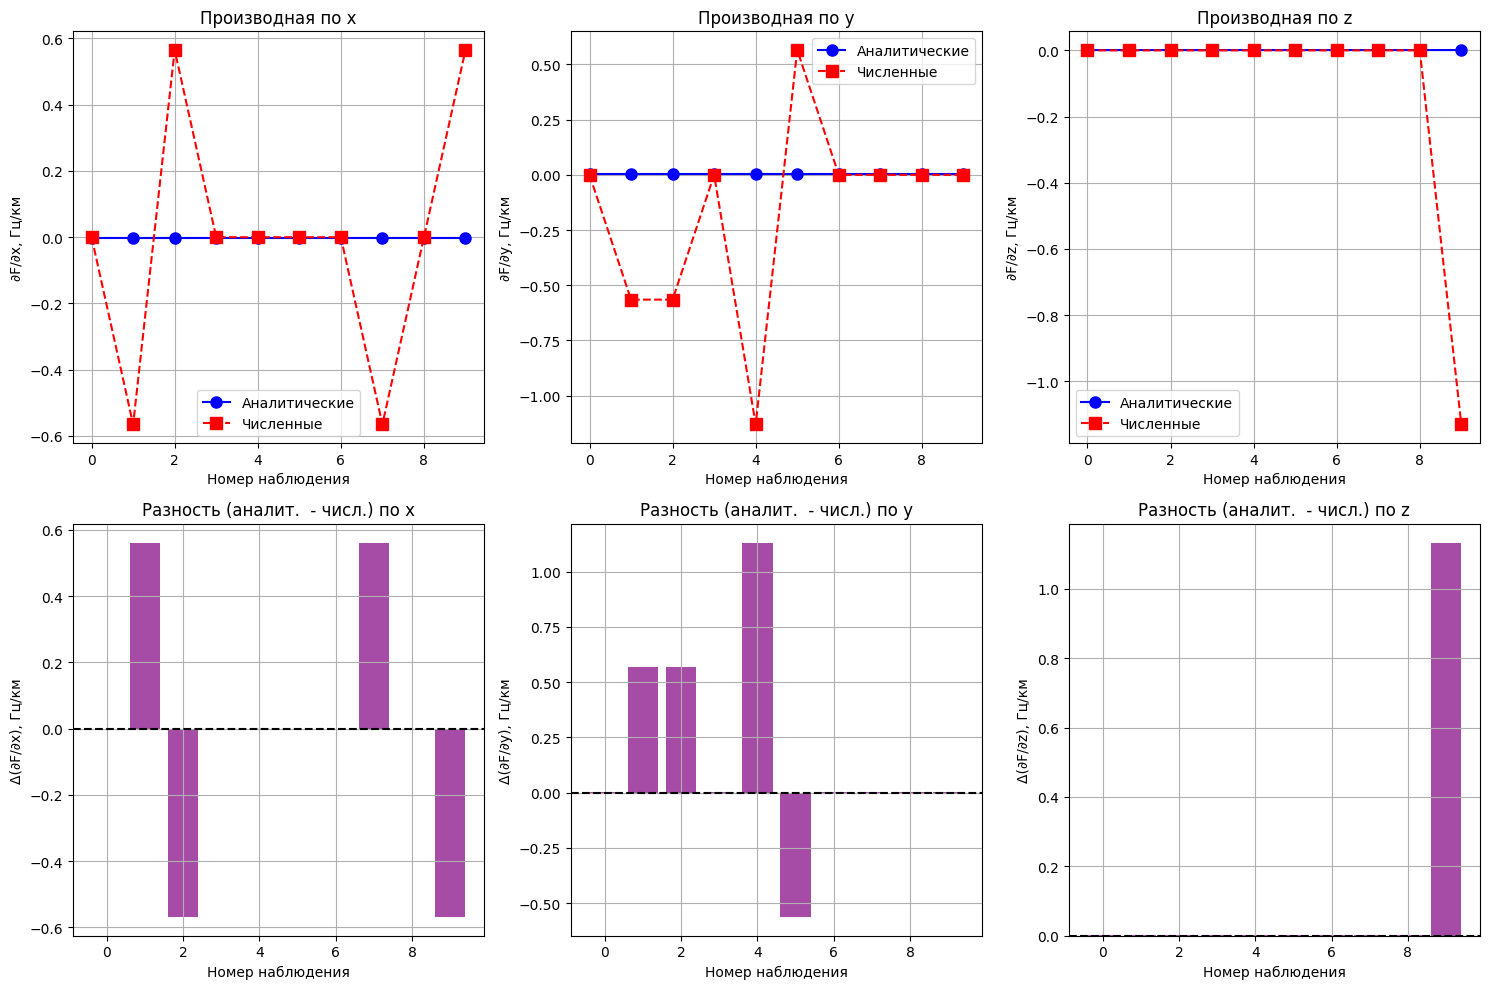


5. ДЕТАЛЬНАЯ ПРОВЕРКА ФОРМУЛ

Наблюдение: 1997-09-19 00:06:30

Световое время:
  t3 (приём) = 1997-09-19T00:06:30.000
  t2 (КА)    = 1997-09-18T23:52:03.665
  t1 (перед) = 1997-09-18T23:37:37.473
  Downleg:    t3 - t2 = 866.334544 сек = 14.44 мин
  Upleg:     t2 - t1 = 866.192057 сек = 14.44 мин
  Round-trip: t3 - t1 = 1732.526600 сек = 28.88 мин

Расстояния:
  |r12| (upleg)   = 259677845.7 км = 866.19 сек света
  |r23| (downleg) = 259720562.4 км = 866.33 сек света

Матрица Φ(t2) = ∂r2/∂β:
  [    1.000000,    -0.000000,     0.000000]
  [   -0.000000,     1.000000,     0.000000]
  [    0.000000,     0.000000,     1.000000]
  det(Φ) = 1.000000

Единичные векторы:
  r̂12 = (-0.599129, -0.727566, -0.334204)
  r̂23 = (0.599042, 0.727626, 0.334228)

Скорости:
  v1 = (1.837488, 26.938653, 11.773141) км/с
  v2 = (25.106836, 1.291291, 0.482222) км/с
  r̂23 · v2 = 16.140806 км/с
  r̂12 · v1 = -24.635178 км/с

Знаменатели:
  c + r̂23·v2 = 299808.598806 км/с
  c + r̂12·v1 = 299767.822822 км/с

∂t

In [2]:
"""
Проверка частных производных с разными шагами и сравнение с аналитическими.
"""

import numpy as np
import pandas as pd
import spiceypy as spice
from scipy. interpolate import interp1d
import os
import matplotlib.pyplot as plt

# ============================================================================
# КОНСТАНТЫ И БАЗОВЫЕ ФУНКЦИИ
# ============================================================================

KERNEL_DIR = './spice_data/'
GEOMETRY_FILE = './output_data/mgs_geometry.csv'
DOPPLER_FILE = './output_data/mgs_doppler_CLEANED.csv'
RAMP_FILE = './output_data/mgs_ramp_CLEANED.csv'
OUTPUT_DIR = './output_data/'

C_LIGHT = 299792.458

GM = {
    'sun': 132712440041.93938, 'mercury': 22031.868551, 'venus':  324858.592,
    'earth': 398600.435507, 'moon': 4902.800118, 'mars': 42828.375816,
    'jupiter': 126712764.100, 'saturn':  37940584.841, 'uranus': 5794556.400,
    'neptune': 6836527.100,
}

BODIES = [(10, GM['sun']), (1, GM['mercury']), (2, GM['venus']),
          (3, GM['earth']), (301, GM['moon']), (4, GM['mars']),
          (5, GM['jupiter']), (6, GM['saturn']), (7, GM['uranus']),
          (8, GM['neptune'])]


def load_kernels():
    kernels = ['naif0010.tls', 'pck00010.tpc', 'earth_720101_070426.bpc',
               'de442s.bsp', 'mgs_ab1.bsp', 'dsnstns.bsp']
    for k in kernels: 
        path = os.path. join(KERNEL_DIR, k)
        if os.path.exists(path):
            try:
                spice.furnsh(path)
            except:
                pass


def get_body_state(body_id, t_et):
    state, _ = spice.spkezr(str(body_id), t_et, 'J2000', 'NONE', '0')
    return np.array(state[: 3]), np.array(state[3:6])


def get_mars_state(t_et):
    return get_body_state(4, t_et)


def get_earth_state(t_et):
    return get_body_state(3, t_et)


def get_dsn_station_state(station_id, t_et):
    station_name = f'DSS-{station_id}'
    try:
        state_earth, _ = spice.spkezr(station_name, t_et, 'J2000', 'NONE', 'EARTH')
        r_st_earth = np.array(state_earth[: 3])
        v_st_earth = np.array(state_earth[3:6])
        r_earth, v_earth = get_earth_state(t_et)
        return r_earth + r_st_earth, v_earth + v_st_earth
    except: 
        return np.zeros(3), np.zeros(3)


# ============================================================================
# ДИНАМИКА И ИНТЕГРИРОВАНИЕ
# ============================================================================

def compute_acceleration(t_et, r_sc_mars, v_sc_mars):
    r_mars, _ = get_mars_state(t_et)
    r_sc_ssb = r_mars + r_sc_mars
    
    a_sc = np. zeros(3)
    a_mars = np.zeros(3)
    
    for naif_id, gm in BODIES: 
        try: 
            r_body, _ = get_body_state(naif_id, t_et)
        except:
            continue
        
        r_to = r_body - r_sc_ssb
        d = np.linalg.norm(r_to)
        if d > 1e-10: 
            a_sc += gm * r_to / d**3
        
        if naif_id != 4:
            r_to_mars = r_body - r_mars
            d_mars = np.linalg.norm(r_to_mars)
            if d_mars > 1e-10:
                a_mars += gm * r_to_mars / d_mars**3
    
    return a_sc - a_mars


def compute_acceleration_jacobian(t_et, r_sc_mars):
    """Якобиан ускорения ∂a/∂r."""
    r_mars, _ = get_mars_state(t_et)
    r_sc_ssb = r_mars + r_sc_mars

    jacobian = np.zeros((3, 3))

    for naif_id, gm in BODIES:
        try:
            r_body, _ = get_body_state(naif_id, t_et)
        except:
            continue

        I = np.eye(3)

        # ---------- вклад КА ----------
        r_sc = r_body - r_sc_ssb
        d_sc = np.linalg.norm(r_sc)

        if d_sc > 1e-10:
            outer_sc = np.outer(r_sc, r_sc)
            jac_sc = -gm * (I / d_sc**3 - 3.0 * outer_sc / d_sc**5)
        else:
            jac_sc = np.zeros((3, 3))

        # ---------- вклад Марса ----------
        r_m = r_body - r_mars
        d_m = np.linalg.norm(r_m)

        if d_m > 1e-10:
            outer_m = np.outer(r_m, r_m)
            jac_m = -gm * (I / d_m**3 - 3.0 * outer_m / d_m**5)
        else:
            jac_m = np.zeros((3, 3))

        # ---------- ОТНОСИТЕЛЬНОЕ УСКОРЕНИЕ ----------
        jacobian += jac_sc - jac_m

    return jacobian

def rk5_step(t, state, dt, t_et_start):
    """RK5 шаг для 6-мерного состояния."""
    c = [0, 1/5, 3/10, 4/5, 8/9, 1, 1]
    a_rk = [[], [1/5], [3/40, 9/40], [44/45, -56/15, 32/9],
            [19372/6561, -25360/2187, 64448/6561, -212/729],
            [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
            [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]]
    b = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]
    
    def f(t_rel, y):
        t_et = t_et_start + t_rel
        return np.concatenate([y[3:6], compute_acceleration(t_et, y[: 3], y[3:6])])
    
    k = [None] * 7
    k[0] = f(t, state)
    
    for i in range(1, 7):
        y_temp = state + dt * sum(a_rk[i][j] * k[j] for j in range(i))
        k[i] = f(t + c[i] * dt, y_temp)
    
    return state + dt * sum(b[i] * k[i] for i in range(7))


def rk5_step_with_variational(t, y, dt, t_et_start):
    """RK5 шаг для состояния + вариационные уравнения (15-мерный вектор)."""
    c = [0, 1/5, 3/10, 4/5, 8/9, 1, 1]
    a_rk = [[], [1/5], [3/40, 9/40], [44/45, -56/15, 32/9],
            [19372/6561, -25360/2187, 64448/6561, -212/729],
            [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
            [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]]
    b = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]
    
    def f(t_rel, y):
        t_et = t_et_start + t_rel
        r = y[0:3]
        v = y[3:6]
        Phi = y[6:15].reshape(3, 3)
        
        a = compute_acceleration(t_et, r, v)
        da_dr = compute_acceleration_jacobian(t_et, r)
        dPhi_dt = da_dr @ Phi
        
        return np.concatenate([v, a, dPhi_dt.flatten()])
    
    k = [None] * 7
    k[0] = f(t, y)
    
    for i in range(1, 7):
        y_temp = y + dt * sum(a_rk[i][j] * k[j] for j in range(i))
        k[i] = f(t + c[i] * dt, y_temp)
    
    return y + dt * sum(b[i] * k[i] for i in range(7))


def integrate_orbit(t0_et, state0, t_end_et, dt=60.0):
    """Интегрирование без вариационных."""
    times = [t0_et]
    states = [state0.copy()]
    
    state = state0.copy()
    t_rel = 0.0
    duration = t_end_et - t0_et
    
    while t_rel < duration: 
        current_dt = min(dt, duration - t_rel)
        state = rk5_step(t_rel, state, current_dt, t0_et)
        t_rel += current_dt
        times. append(t0_et + t_rel)
        states.append(state.copy())
    
    return {'times': np.array(times), 'states': np.array(states)}


def integrate_orbit_with_variational(t0_et, state0, t_end_et, dt=60.0):
    """Интегрирование с вариационными уравнениями."""
    y0 = np.zeros(15)
    y0[0:6] = state0
    y0[6:15] = np.eye(3).flatten()  # Φ(t0) = I
    
    times = [t0_et]
    states = [state0.copy()]
    Phi_list = [np.eye(3)]
    
    y = y0.copy()
    t_rel = 0.0
    duration = t_end_et - t0_et
    
    while t_rel < duration:
        current_dt = min(dt, duration - t_rel)
        y = rk5_step_with_variational(t_rel, y, current_dt, t0_et)
        t_rel += current_dt
        times. append(t0_et + t_rel)
        states.append(y[0:6].copy())
        Phi_list.append(y[6:15].reshape(3, 3).copy())
    
    return {
        'times':  np.array(times),
        'states':  np.array(states),
        'Phi':  Phi_list
    }


def create_interpolator(orbit_data):
    times = orbit_data['times']
    states = orbit_data['states']
    
    interp_r = interp1d(times, states[: , : 3], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    interp_v = interp1d(times, states[:, 3:6], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    
    def get_sc_state_ssb(t):
        r_mars, v_mars = get_mars_state(t)
        return r_mars + interp_r(t), v_mars + interp_v(t)
    
    return get_sc_state_ssb


def create_interpolators_with_Phi(orbit_data):
    times = orbit_data['times']
    states = orbit_data['states']
    Phi_list = orbit_data['Phi']
    
    interp_r = interp1d(times, states[:, :3], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    interp_v = interp1d(times, states[:, 3:6], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    
    Phi_array = np.array([phi.flatten() for phi in Phi_list])
    interp_Phi = interp1d(times, Phi_array, axis=0, kind='cubic',
                          fill_value='extrapolate', bounds_error=False)
    
    def get_sc_state_ssb(t):
        r_mars, v_mars = get_mars_state(t)
        return r_mars + interp_r(t), v_mars + interp_v(t)
    
    def get_Phi(t):
        return interp_Phi(t).reshape(3, 3)
    
    return get_sc_state_ssb, get_Phi


# ============================================================================
# СВЕТОВОЕ ВРЕМЯ И ДОПЛЕР
# ============================================================================

def solve_light_time(t_recv, get_sc_state_ssb, station_id, max_iter=20, tol=1e-12):
    t3 = t_recv
    t2 = t3
    t1 = t3
    
    for _ in range(max_iter):
        r3_ssb, v3_ssb = get_dsn_station_state(station_id, t3)
        r2_ssb, v2_ssb = get_sc_state_ssb(t2)
        
        rho_dn = np.linalg.norm(r3_ssb - r2_ssb)
        t2_new = t3 - rho_dn / C_LIGHT
        
        r2_ssb_new, v2_ssb_new = get_sc_state_ssb(t2_new)
        r1_ssb, v1_ssb = get_dsn_station_state(station_id, t1)
        
        rho_up = np.linalg.norm(r2_ssb_new - r1_ssb)
        t1_new = t2_new - rho_up / C_LIGHT
        
        if abs(t1_new - t1) < tol and abs(t2_new - t2) < tol: 
            t1, t2 = t1_new, t2_new
            break
        
        t1, t2 = t1_new, t2_new
    
    # Возвращаем полную информацию
    r1_ssb, v1_ssb = get_dsn_station_state(station_id, t1)
    r2_ssb, v2_ssb = get_sc_state_ssb(t2)
    r3_ssb, v3_ssb = get_dsn_station_state(station_id, t3)
    
    return {
        't1': t1, 't2': t2, 't3': t3,
        'r1':  r1_ssb, 'r2': r2_ssb, 'r3': r3_ssb,
        'v1':  v1_ssb, 'v2': v2_ssb, 'v3': v3_ssb
    }


def compute_ramp_integral(t_start, t_end, station_id, ramp_df):
    station_ramp = ramp_df[ramp_df['ramp_station_id'] == station_id].sort_values('ramp_start_et')
    ramp_times = station_ramp['ramp_start_et'].values
    ramp_freqs = station_ramp['ramp_start_freq_hz'].values
    ramp_rates = station_ramp['ramp_rate_hz_s'].values
    
    if len(ramp_times) == 0:
        return 0.0
    
    total = 0.0
    current = t_start
    
    while current < t_end:
        idx = np.searchsorted(ramp_times, current, side='right') - 1
        idx = max(0, min(idx, len(ramp_times) - 1))
        
        t_ramp_start = ramp_times[idx]
        t_ramp_end = ramp_times[idx + 1] if idx + 1 < len(ramp_times) else t_end
        t_interval_end = min(t_ramp_end, t_end)
        
        f0 = ramp_freqs[idx]
        f_dot = ramp_rates[idx]
        
        t_rel_start = current - t_ramp_start
        t_rel_end = t_interval_end - t_ramp_start
        
        total += f0 * (t_rel_end - t_rel_start) + 0.5 * f_dot * (t_rel_end**2 - t_rel_start**2)
        current = t_interval_end
    
    return total


def get_transmitter_freq(t_et, station_id, ramp_df):
    station_ramp = ramp_df[ramp_df['ramp_station_id'] == station_id].sort_values('ramp_start_et')
    ramp_times = station_ramp['ramp_start_et'].values
    ramp_freqs = station_ramp['ramp_start_freq_hz'].values
    ramp_rates = station_ramp['ramp_rate_hz_s'].values
    
    if len(ramp_times) == 0:
        return 7.164e9
    
    idx = np.searchsorted(ramp_times, t_et, side='right') - 1
    idx = max(0, min(idx, len(ramp_times) - 1))
    
    t_ramp_start = ramp_times[idx]
    f0 = ramp_freqs[idx]
    f_dot = ramp_rates[idx]
    
    return f0 + f_dot * (t_et - t_ramp_start)


def compute_doppler(t3, Tc, ramp_df, get_sc_state_ssb, station_id):
    """Вычисляет модельный доплер."""
    M2 = 880.0 / 749.0
    
    t3_start = t3 - 0.5 * Tc
    t3_end = t3 + 0.5 * Tc
    
    lt_start = solve_light_time(t3_start, get_sc_state_ssb, station_id)
    lt_end = solve_light_time(t3_end, get_sc_state_ssb, station_id)
    
    t1_start = lt_start['t1']
    t1_end = lt_end['t1']
    
    I_rx = compute_ramp_integral(t3_start, t3_end, station_id, ramp_df)
    I_tx = compute_ramp_integral(t1_start, t1_end, station_id, ramp_df)
    
    doppler = (M2 * (I_rx - I_tx) / Tc - 450000.0) / 2.22
    
    return doppler


# ============================================================================
# АНАЛИТИЧЕСКИЕ ПРОИЗВОДНЫЕ (по формулам Moyer)
# ============================================================================

def compute_light_time_partials(lt_data, get_Phi):
    """
    Вычисляет ∂ρ/∂β по формулам Moyer (12-12, 12-17, 12-23).
    """
    t2 = lt_data['t2']
    
    r1 = lt_data['r1']
    r2 = lt_data['r2']
    r3 = lt_data['r3']
    
    v1 = lt_data['v1']
    v2 = lt_data['v2']
    
    r12 = r2 - r1  # upleg
    r23 = r3 - r2  # downleg
    
    r12_norm = np.linalg.norm(r12)
    r23_norm = np.linalg. norm(r23)
    
    r12_hat = r12 / r12_norm
    r23_hat = r23 / r23_norm
    
    # Матрица ∂r2/∂β из вариационных уравнений
    Phi = get_Phi(t2)  # 3x3
    dr2_dbeta = Phi
    
    # Формула 12-12:  ∂t2/∂q (downleg)
    denominator_t2 = C_LIGHT + np.dot(r23_hat, v2)
    dt2_dbeta = (r23_hat @ dr2_dbeta) / denominator_t2  # (3,)
    
    # Формула 12-17: ∂t1/∂q (upleg)
    denominator_t1 = C_LIGHT + np.dot(r12_hat, v1)
    term = dr2_dbeta + np.outer(v2, dt2_dbeta)  # (3,3)
    dt1_dbeta = (r12_hat @ term) / denominator_t1  # (3,)
    
    # Формула 12-23: ∂ρ/∂q = -∂t1/∂q
    drho_dbeta = -dt1_dbeta
    
    return drho_dbeta


def compute_doppler_partial_analytical(t3, Tc, ramp_df, get_sc_state_ssb, get_Phi, station_id):
    """
    Вычисляет ∂F2/∂β аналитически по формуле 13-59 Moyer. 
    """
    M2 = 880.0 / 749.0
    
    t3_start = t3 - 0.5 * Tc
    t3_end = t3 + 0.5 * Tc
    
    lt_start = solve_light_time(t3_start, get_sc_state_ssb, station_id)
    lt_end = solve_light_time(t3_end, get_sc_state_ssb, station_id)
    
    f_t_start = get_transmitter_freq(lt_start['t1'], station_id, ramp_df)
    f_t_end = get_transmitter_freq(lt_end['t1'], station_id, ramp_df)
    
    drho_dbeta_start = compute_light_time_partials(lt_start, get_Phi)
    drho_dbeta_end = compute_light_time_partials(lt_end, get_Phi)
    
    # Формула 13-59
    dF2_dbeta = (M2 / Tc) * (f_t_end * drho_dbeta_end - f_t_start * drho_dbeta_start)
    
    return dF2_dbeta


# ============================================================================
# ЧИСЛЕННЫЕ ПРОИЗВОДНЫЕ
# ============================================================================

def compute_doppler_partial_numerical(t0_et, state0, t3, Tc, ramp_df, station_id, delta=1.0):
    """
    Вычисляет ∂F/∂β численно методом центральных разностей. 
    """
    t_end_et = t3 + 3600
    
    partials = np.zeros(3)
    
    for i in range(3):
        # +delta
        state_plus = state0. copy()
        state_plus[i] += delta
        orbit_plus = integrate_orbit(t0_et, state_plus, t_end_et)
        get_sc_plus = create_interpolator(orbit_plus)
        F_plus = compute_doppler(t3, Tc, ramp_df, get_sc_plus, station_id)
        
        # -delta
        state_minus = state0.copy()
        state_minus[i] -= delta
        orbit_minus = integrate_orbit(t0_et, state_minus, t_end_et)
        get_sc_minus = create_interpolator(orbit_minus)
        F_minus = compute_doppler(t3, Tc, ramp_df, get_sc_minus, station_id)
        
        partials[i] = (F_plus - F_minus) / (2 * delta)
    
    return partials


# ============================================================================
# MAIN
# ============================================================================

def main():
    print("=" * 70)
    print("СРАВНЕНИЕ АНАЛИТИЧЕСКИХ И ЧИСЛЕННЫХ ПРОИЗВОДНЫХ")
    print("=" * 70)
    
    load_kernels()
    
    # Загрузка данных
    geometry_df = pd.read_csv(GEOMETRY_FILE)
    geometry_df['datetime_utc'] = pd. to_datetime(geometry_df['datetime_utc'])
    row = geometry_df. iloc[0]
    t0_et = spice.str2et(row['datetime_utc']. strftime('%Y-%m-%dT%H:%M:%S'))
    state0 = np.array([
        row['mgs_x_km'], row['mgs_y_km'], row['mgs_z_km'],
        row['mgs_vx_km_s'], row['mgs_vy_km_s'], row['mgs_vz_km_s'],
    ])
    
    doppler_df = pd.read_csv(DOPPLER_FILE)
    doppler_df['datetime_utc'] = pd.to_datetime(doppler_df['datetime_utc'])
    
    ramp_df = pd.read_csv(RAMP_FILE)
    ramp_df['ramp_datetime_utc'] = pd.to_datetime(ramp_df['ramp_datetime_utc'])
    ramp_df['ramp_start_et'] = ramp_df['ramp_datetime_utc']. apply(lambda x: spice. str2et(str(x)))
    
    print(f"\nНачальное состояние:")
    print(f"  r₀ = ({state0[0]:.3f}, {state0[1]:.3f}, {state0[2]:.3f}) км")
    print(f"  v₀ = ({state0[3]:.6f}, {state0[4]:.6f}, {state0[5]:.6f}) км/с")
    
    # Тестовые наблюдения
    test_obs = doppler_df. head(10)
    
    # =========================================================================
    # 1. Проверка численных производных с разными шагами
    # =========================================================================
    print("\n" + "=" * 70)
    print("1. ЧИСЛЕННЫЕ ПРОИЗВОДНЫЕ С РАЗНЫМИ ШАГАМИ delta")
    print("=" * 70)
    
    deltas = [0.01, 0.1, 1.0, 10.0, 100.0]
    
    # Берём одно наблюдение
    obs_row = test_obs. iloc[5]
    t3 = spice.str2et(str(obs_row['datetime_utc']))
    Tc = obs_row['compression_time']
    station_id = int(obs_row['receiving_station_id'])
    
    print(f"\nНаблюдение:  {obs_row['datetime_utc']}")
    print(f"Tc = {Tc} сек, станция = {station_id}")
    
    print(f"\n{'delta (км)':<12} {'∂F/∂x':<16} {'∂F/∂y':<16} {'∂F/∂z':<16} {'|∂F/∂β|':<16}")
    print("-" * 76)
    
    for delta in deltas:
        partials = compute_doppler_partial_numerical(t0_et, state0, t3, Tc, ramp_df, station_id, delta)
        print(f"{delta:<12.2f} {partials[0]:<16.6e} {partials[1]:<16.6e} {partials[2]: <16.6e} {np.linalg.norm(partials):<16.6e}")
    
    # =========================================================================
    # 2. Сравнение аналитических и численных для нескольких наблюдений
    # =========================================================================
    print("\n" + "=" * 70)
    print("2. СРАВНЕНИЕ АНАЛИТИЧЕСКИХ И ЧИСЛЕННЫХ ПРОИЗВОДНЫХ")
    print("=" * 70)
    
    # Интегрируем с вариационными уравнениями
    t_end_et = spice.str2et(str(test_obs['datetime_utc'].max())) + 3600
    print("\nИнтегрирование орбиты с вариационными уравнениями...")
    orbit_data = integrate_orbit_with_variational(t0_et, state0, t_end_et)
    get_sc_state_ssb, get_Phi = create_interpolators_with_Phi(orbit_data)
    
    # Проверяем матрицу Φ
    print("\nПроверка матрицы Φ = ∂r/∂β:")
    for i in range(0, len(orbit_data['times']), max(1, len(orbit_data['times'])//5)):
        t = orbit_data['times'][i]
        Phi = orbit_data['Phi'][i]
        print(f"  t = {spice.et2utc(t, 'ISOC', 0)[: 19]}")
        print(f"    Φ = [{Phi[0,0]: 10.4f}, {Phi[0,1]:10.4f}, {Phi[0,2]:10.4f}]")
        print(f"        [{Phi[1,0]:10.4f}, {Phi[1,1]:10.4f}, {Phi[1,2]:10.4f}]")
        print(f"        [{Phi[2,0]:10.4f}, {Phi[2,1]:10.4f}, {Phi[2,2]:10.4f}]")
        print(f"    det(Φ) = {np.linalg.det(Phi):.6f}, ||Φ-I|| = {np.linalg.norm(Phi - np.eye(3)):.6f}")
    
    # Сравнение производных
    delta = 10.0  # км - оптимальный шаг
    
    print(f"\n\nСравнение (delta = {delta} км для численных):")
    print("-" * 120)
    print(f"{'№':<4} {'Время':<20} | {'Аналит.  ∂F/∂x':<14} {'Числ. ∂F/∂x':<14} | {'Аналит. ∂F/∂y':<14} {'Числ. ∂F/∂y':<14} | {'Аналит. ∂F/∂z':<14} {'Числ.  ∂F/∂z':<14}")
    print("-" * 120)
    
    analytical_partials = []
    numerical_partials = []
    
    for idx, obs_row in test_obs.iterrows():
        t3 = spice.str2et(str(obs_row['datetime_utc']))
        Tc = obs_row['compression_time']
        station_id = int(obs_row['receiving_station_id'])
        
        # Аналитические
        p_anal = compute_doppler_partial_analytical(t3, Tc, ramp_df, get_sc_state_ssb, get_Phi, station_id)
        
        # Численные
        p_num = compute_doppler_partial_numerical(t0_et, state0, t3, Tc, ramp_df, station_id, delta)
        
        analytical_partials. append(p_anal)
        numerical_partials.append(p_num)
        
        print(f"{idx:<4} {str(obs_row['datetime_utc'])[: 19]:<20} | "
              f"{p_anal[0]:<14.4e} {p_num[0]:<14.4e} | "
              f"{p_anal[1]:<14.4e} {p_num[1]:<14.4e} | "
              f"{p_anal[2]:<14.4e} {p_num[2]:<14.4e}")
    
    analytical_partials = np.array(analytical_partials)
    numerical_partials = np.array(numerical_partials)
    
    # =========================================================================
    # 3. Анализ расхождений
    # =========================================================================
    print("\n" + "=" * 70)
    print("3. АНАЛИЗ РАСХОЖДЕНИЙ")
    print("=" * 70)
    
    diff = analytical_partials - numerical_partials
    
    print("\nСредние значения:")
    print(f"  Аналитические: ∂F/∂x = {analytical_partials[:,0].mean():.4e}, "
          f"∂F/∂y = {analytical_partials[:,1]. mean():.4e}, "
          f"∂F/∂z = {analytical_partials[:,2]. mean():.4e}")
    print(f"  Численные:      ∂F/∂x = {numerical_partials[:,0].mean():.4e}, "
          f"∂F/∂y = {numerical_partials[:,1].mean():.4e}, "
          f"∂F/∂z = {numerical_partials[:,2].mean():.4e}")
    print(f"  Разность:      ∂F/∂x = {diff[:,0].mean():.4e}, "
          f"∂F/∂y = {diff[:,1].mean():.4e}, "
          f"∂F/∂z = {diff[:,2].mean():.4e}")
    
    # Относительная ошибка
    rel_error = np. abs(diff) / (np.abs(numerical_partials) + 1e-10)
    print(f"\nСредняя относительная ошибка:")
    print(f"  ∂F/∂x:  {rel_error[:,0].mean()*100:.2f}%")
    print(f"  ∂F/∂y: {rel_error[:,1].mean()*100:.2f}%")
    print(f"  ∂F/∂z: {rel_error[:,2].mean()*100:.2f}%")
    
    # =========================================================================
    # 4. Визуализация
    # =========================================================================
    print("\n" + "=" * 70)
    print("4. ПОСТРОЕНИЕ ГРАФИКОВ")
    print("=" * 70)
    
    fig, axes = plt. subplots(2, 3, figsize=(15, 10))
    
    obs_indices = range(len(test_obs))
    
    # Верхний ряд:  сравнение
    for i, label in enumerate(['x', 'y', 'z']):
        ax = axes[0, i]
        ax.plot(obs_indices, analytical_partials[: , i], 'bo-', label='Аналитические', markersize=8)
        ax.plot(obs_indices, numerical_partials[:, i], 'rs--', label='Численные', markersize=8)
        ax.set_xlabel('Номер наблюдения')
        ax.set_ylabel(f'∂F/∂{label}, Гц/км')
        ax.set_title(f'Производная по {label}')
        ax.legend()
        ax.grid(True)
    
    # Нижний ряд: разность
    for i, label in enumerate(['x', 'y', 'z']):
        ax = axes[1, i]
        ax. bar(obs_indices, diff[:, i], color='purple', alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='--')
        ax.set_xlabel('Номер наблюдения')
        ax.set_ylabel(f'Δ(∂F/∂{label}), Гц/км')
        ax.set_title(f'Разность (аналит.  - числ.) по {label}')
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'partials_comparison.png'), dpi=150)
    plt.show()
    
    # =========================================================================
    # 5. Проверка формул по отдельности
    # =========================================================================
    print("\n" + "=" * 70)
    print("5. ДЕТАЛЬНАЯ ПРОВЕРКА ФОРМУЛ")
    print("=" * 70)
    
    # Берём одно наблюдение для детального анализа
    obs_row = test_obs.iloc[5]
    t3 = spice. str2et(str(obs_row['datetime_utc']))
    Tc = obs_row['compression_time']
    station_id = int(obs_row['receiving_station_id'])
    
    print(f"\nНаблюдение: {obs_row['datetime_utc']}")
    
    # Световое время
    lt = solve_light_time(t3, get_sc_state_ssb, station_id)
    
    print(f"\nСветовое время:")
    print(f"  t3 (приём) = {spice.et2utc(lt['t3'], 'ISOC', 3)}")
    print(f"  t2 (КА)    = {spice. et2utc(lt['t2'], 'ISOC', 3)}")
    print(f"  t1 (перед) = {spice.et2utc(lt['t1'], 'ISOC', 3)}")
    print(f"  Downleg:    t3 - t2 = {lt['t3'] - lt['t2']:.6f} сек = {(lt['t3'] - lt['t2'])/60:.2f} мин")
    print(f"  Upleg:     t2 - t1 = {lt['t2'] - lt['t1']:.6f} сек = {(lt['t2'] - lt['t1'])/60:.2f} мин")
    print(f"  Round-trip: t3 - t1 = {lt['t3'] - lt['t1']:.6f} сек = {(lt['t3'] - lt['t1'])/60:.2f} мин")
    
    # Расстояния
    r12 = lt['r2'] - lt['r1']
    r23 = lt['r3'] - lt['r2']
    print(f"\nРасстояния:")
    print(f"  |r12| (upleg)   = {np.linalg. norm(r12):.1f} км = {np.linalg. norm(r12)/C_LIGHT:.2f} сек света")
    print(f"  |r23| (downleg) = {np.linalg.norm(r23):.1f} км = {np.linalg.norm(r23)/C_LIGHT:.2f} сек света")
    
    # Матрица Φ в момент t2
    Phi_t2 = get_Phi(lt['t2'])
    print(f"\nМатрица Φ(t2) = ∂r2/∂β:")
    print(f"  [{Phi_t2[0,0]: 12.6f}, {Phi_t2[0,1]:12.6f}, {Phi_t2[0,2]:12.6f}]")
    print(f"  [{Phi_t2[1,0]:12.6f}, {Phi_t2[1,1]: 12.6f}, {Phi_t2[1,2]:12.6f}]")
    print(f"  [{Phi_t2[2,0]:12.6f}, {Phi_t2[2,1]:12.6f}, {Phi_t2[2,2]:12.6f}]")
    print(f"  det(Φ) = {np.linalg.det(Phi_t2):.6f}")
    
    # Проверка промежуточных вычислений
    r12_hat = r12 / np.linalg. norm(r12)
    r23_hat = r23 / np.linalg.norm(r23)
    
    print(f"\nЕдиничные векторы:")
    print(f"  r̂12 = ({r12_hat[0]:.6f}, {r12_hat[1]:.6f}, {r12_hat[2]:.6f})")
    print(f"  r̂23 = ({r23_hat[0]:.6f}, {r23_hat[1]:.6f}, {r23_hat[2]:.6f})")
    
    print(f"\nСкорости:")
    print(f"  v1 = ({lt['v1'][0]:.6f}, {lt['v1'][1]:.6f}, {lt['v1'][2]:.6f}) км/с")
    print(f"  v2 = ({lt['v2'][0]:.6f}, {lt['v2'][1]:.6f}, {lt['v2'][2]:.6f}) км/с")
    print(f"  r̂23 · v2 = {np.dot(r23_hat, lt['v2']):.6f} км/с")
    print(f"  r̂12 · v1 = {np.dot(r12_hat, lt['v1']):.6f} км/с")
    
    # Знаменатели формул
    denom_t2 = C_LIGHT + np.dot(r23_hat, lt['v2'])
    denom_t1 = C_LIGHT + np. dot(r12_hat, lt['v1'])
    print(f"\nЗнаменатели:")
    print(f"  c + r̂23·v2 = {denom_t2:.6f} км/с")
    print(f"  c + r̂12·v1 = {denom_t1:.6f} км/с")
    
    # ∂t2/∂β
    dt2_dbeta = (r23_hat @ Phi_t2) / denom_t2
    print(f"\n∂t2/∂β (формула 12-12):")
    print(f"  = ({dt2_dbeta[0]:.6e}, {dt2_dbeta[1]:.6e}, {dt2_dbeta[2]:.6e}) сек/км")
    
    # ∂t1/∂β
    term = Phi_t2 + np.outer(lt['v2'], dt2_dbeta)
    dt1_dbeta = (r12_hat @ term) / denom_t1
    print(f"\n∂t1/∂β (формула 12-17):")
    print(f"  = ({dt1_dbeta[0]:.6e}, {dt1_dbeta[1]:.6e}, {dt1_dbeta[2]:.6e}) сек/км")
    
    # ∂ρ/∂β
    drho_dbeta = -dt1_dbeta
    print(f"\n∂ρ/∂β (формула 12-23):")
    print(f"  = ({drho_dbeta[0]:.6e}, {drho_dbeta[1]:.6e}, {drho_dbeta[2]:.6e}) сек/км")
    
    # Частота передатчика
    f_t = get_transmitter_freq(lt['t1'], station_id, ramp_df)
    print(f"\nЧастота передатчика:")
    print(f"  f_t(t1) = {f_t:.6e} Гц = {f_t/1e9:.6f} ГГц")
    
    # ∂F/∂β
    M2 = 880.0 / 749.0
    dF_dbeta_simple = M2 * f_t * drho_dbeta / Tc
    print(f"\n∂F/∂β (упрощённо, без учёта разности):")
    print(f"  = ({dF_dbeta_simple[0]:.6e}, {dF_dbeta_simple[1]:.6e}, {dF_dbeta_simple[2]:.6e}) Гц/км")
    
    # Сравнение
    p_anal = compute_doppler_partial_analytical(t3, Tc, ramp_df, get_sc_state_ssb, get_Phi, station_id)
    p_num = compute_doppler_partial_numerical(t0_et, state0, t3, Tc, ramp_df, station_id, delta=10.0)
    
    print(f"\nИтоговое сравнение:")
    print(f"  Аналитические: ({p_anal[0]:.6e}, {p_anal[1]:.6e}, {p_anal[2]:.6e}) Гц/км")
    print(f"  Численные:     ({p_num[0]:.6e}, {p_num[1]:.6e}, {p_num[2]:.6e}) Гц/км")
    
    spice. kclear()
    print("\n✓ Проверка завершена!")


if __name__ == "__main__": 
    main()